In [1]:
import os
import socket
import joblib
import numpy as np
import random
from Evaluation import evaluation
from Plotting import plotting as plotting_utils
from Preprocessing import preprocessing
import sys
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
from sklearn import metrics

%pylab inline
%load_ext autoreload
%autoreload 2
print(socket.gethostname())

/usr/local/apps/Anaconda3/2020.11/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.5.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
/usr/local/apps/Anaconda3/2020.11/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered thes

Populating the interactive namespace from numpy and matplotlib
ift-dgx


In [2]:
Y_columns = {'subId': 0,
 'session': 1,
 'round': 2,
 'trial': 3}

Y_columns_judo = {'subId': 0,
 'session': 1,
 'trialId': 2,
 'seqId': 3,
 'original_trial_length_before_padding': 4}

ethnicity_mapping = {'African':'Black',
                     'African American':'Black',
                     'African-American':'Black',
                     'Asian':'Asian',
                     'Asian/White':'Mixed',
                     'Black':'Black',
                     'Black/Hispanic':'Mixed',
                     'Caucasian':'Caucasian',
                     'Caucasian/Hispanic':'Mixed',
                     'European':'Caucasian',
                     'Hiaspanic/Black/Arab':'Mixed',
                     'Hispanic':'Hispanic',
                     'Hispanic/Caucasian':'Mixed',
                     'Hispanic/Latino':'Hispanic',
                     'Hispanic/Native American':'Mixed',
                     'Hispanic/While':'Mixed',
                     'Hispanic/White':'Mixed',
                     'Latina':'Hispanic',
                     'Lau':'Mixed',
                     'Mexican':'Hispanic',
                     'Mexican American':'Mixed',
                     'Mexican/Hispanic':'Hispanic',
                     'Middle-Eastern':'Mixed', #??
                     'Mixed':'Mixed',
                     'Multiracial':'Mixed',
                     'Native American':'Mixed', #??
                     'West Indian':'Mixed',
                     'White':'Caucasian',
                     'White-Hispanic':'Mixed',
                     'White/Hispanic':'Mixed',
                     'White/Mexican':'Mixed',
                     'White/Mexican American':'Mixed',
                     'Whtie':'Caucasian'}

age_mapping = {'young_threshold':20,
               'old_threshold': 30}

### Load demographic data

In [3]:
demo_info_df = pd.read_excel('GazeBase_v2_0/GazeBaseDemoInfo.xlsx')

demo_list = ['Age',
             'Self-Identified Gender',
             'Self-Identified Ethnicity',
             'normalized Ethnicity',
             'age_class']

ethno_list = list(demo_info_df['Self-Identified Ethnicity'])
normalized_ethno_list = []
for i in range(len(ethno_list)):
    normalized_ethno_list.append(ethnicity_mapping[ethno_list[i]])
demo_info_df['normalized Ethnicity'] = list(normalized_ethno_list)

age_list = []
age = list(demo_info_df['Age'])
for i in range(len(age)):
    cur_class = 'between'
    if age[i] <= age_mapping['young_threshold']:
        cur_class = 'Age <= 20'
    if age[i] >= age_mapping['old_threshold']:
        cur_class = 'Age >= 30'
    age_list.append(cur_class)
demo_info_df['age_class'] = list(age_list)

demo_dict = dict()
for i in range(len(demo_info_df)):
    cur_line = demo_info_df.iloc[i]
    cur_part = cur_line['Participant ID']
    for demo_type in demo_list:
        if demo_type not in demo_dict:
            demo_dict[demo_type] = dict()
        demo_dict[demo_type][cur_part] = cur_line[demo_type]

In [4]:
demo_info_df.head()

,Participant ID,Age,Self-Identified Gender,Self-Identified Ethnicity,normalized Ethnicity,age_class
0,1,30,Male,Hispanic,Hispanic,Age >= 30
1,2,18,Male,White,Caucasian,Age <= 20
2,3,19,Male,Mixed,Mixed,Age <= 20
3,4,19,Female,Hispanic,Hispanic,Age <= 20
4,5,22,Male,White,Caucasian,between


In [5]:
embedding_paths = ["saved_lohr_embeddings/key_random_trials_['TEX']_fold_0.npz"]
embedding_paths = ["saved_lohr_embeddings/fix_key_random_trials_['TEX']_fold_0.npz"]
#embedding_paths = ["saved_lohr_embeddings/sac_key_random_trials_['TEX']_fold_0.npz"]
#embedding_paths = ["saved_lohr_embeddings_adam_w/sac_key_random_trials_['TEX']_fold_0.npz"]
weight_list = [1.]
embedding_paths = ["saved_lohr_embeddings/sac_key_random_trials_['TEX']_fold_0.npz",
                      "saved_lohr_embeddings/fix_key_random_trials_['TEX']_fold_0.npz",
                      "saved_lohr_embeddings/pso_key_random_trials_['TEX']_fold_0.npz"]
weight_list = [.77,.08,.15]
session_key = 'session'
seq_id_key = 'round'
subject_key = 'subId'

In [6]:
embedding_list = []
Y_test_list = []
for j in range(len(embedding_paths)):
    cur_data = np.load(embedding_paths[j])
    embeddings=cur_data['embeddings']
    Y_test=cur_data['Y_test']
    embedding_list.append(embeddings)
    Y_test_list.append(Y_test)

In [7]:
# returns embeddings for specific user for specific round and session
def get_embeddings_for_user(user_id,round_id,session_id,
                        embeddings,rounds,sessions,users):
    use_ids = np.logical_and(np.isin(users,user_id),
                            np.logical_and(np.isin(rounds,round_id),
                                          np.isin(sessions,session_id)))
    return embeddings[use_ids]

# create weighted average
def create_weighted_average(embedding_vectors,weights):
    mean_embeddings = []
    for i in range(len(embedding_vectors)):
        mean_embeddings.append(np.mean(embedding_vectors[i],axis=0))
    mean_embedding = []
    for i in range(len(mean_embeddings)):
        if i == 0:
            mean_embedding = weights[i] * mean_embeddings[i]
        else:
            mean_embedding += weights[i] * mean_embeddings[i]
    return mean_embedding

score_dicts = dict()
label_dicts = dict()
person_one_dicts = dict()
person_two_dicts = dict()

score_dicts = dict()
label_dicts = dict()
person_one_dicts = dict()
person_two_dicts = dict()

test_user_list = []
test_sessions_list = []
test_seqIds_list = []
for i in range(len(embedding_list)):
    test_user_list.append(Y_test_list[i][:, Y_columns[subject_key]])
    test_sessions_list.append(Y_test_list[i][:, Y_columns[session_key]])
    test_seqIds_list.append(Y_test_list[i][:, Y_columns[seq_id_key]])

unique_rounds = list(np.unique(test_seqIds_list[0]))
unique_users = list(np.unique(test_user_list[0]))



enrollments = []
user = []

for c_round in unique_rounds:
    for c_user in unique_users:
        # get embedding vectors
        embedding_vectors = []
        lens = []
        for i in range(len(embedding_list)):
            cur_embedding = get_embeddings_for_user(c_user,c_round,0,
                                                   embedding_list[i],test_seqIds_list[i],
                                                   test_sessions_list[i],test_user_list[i])
            embedding_vectors.append(cur_embedding)
            lens.append(cur_embedding.shape[0])
        if np.sum(np.array(lens) == 0) == 0:
            # create weighted average
            mean_embedding = create_weighted_average(embedding_vectors,weight_list)
            enrollments.append(mean_embedding)
            user.append(c_user)

        # get test vectors
        embedding_vectors = []
        lens = []
        for i in range(len(embedding_list)):
            cur_embedding = get_embeddings_for_user(c_user,c_round,1,
                                                   embedding_list[i],test_seqIds_list[i],
                                                   test_sessions_list[i],test_user_list[i])
            embedding_vectors.append(cur_embedding)
            lens.append(cur_embedding.shape[0])
        if np.sum(np.array(lens) == 0) == 0:
            # create weighted average
            mean_embedding = create_weighted_average(embedding_vectors,weight_list)
            enrollments.append(mean_embedding)
            user.append(c_user)

In [8]:
Y_columns

{'subId': 0, 'session': 1, 'round': 2, 'trial': 3}

In [9]:
mean_embeddings = np.array(enrollments)
mean_users      = np.array(user)

/usr/local/apps/Anaconda3/2020.11/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/apps/Anaconda3/2020.11/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


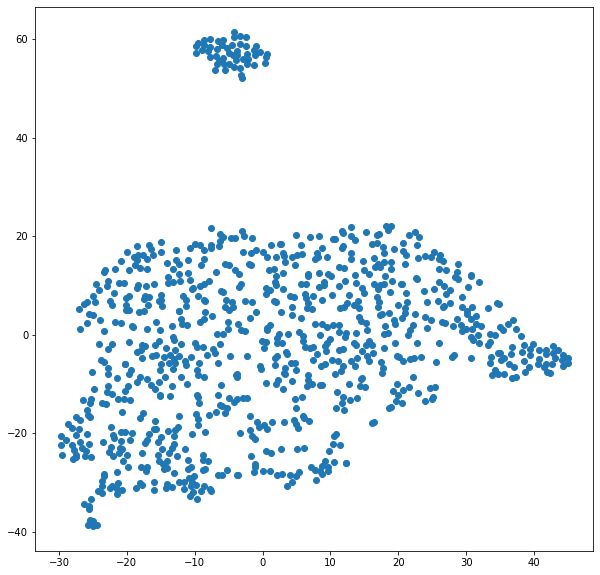

In [10]:
from sklearn.manifold import TSNE

joblib_path = 'plots/t-sne_data_lohr.joblib'
flag_redo = True

if os.path.exists(joblib_path) and not flag_redo:
    joblib_data = joblib.load(joblib_path)
    mean_embeddings=joblib_data['mean_embeddings']
    mean_users=joblib_data['mean_users']
    X_reduced = joblib_data['X_reduced']
else:
    n_components = 2
    random_state = 42

    X_reduced = TSNE(n_components=n_components, init="pca", random_state=random_state).fit_transform(mean_embeddings)

    joblib.dump({'mean_embeddings':mean_embeddings,
                 'mean_users':mean_users,
                 'X_reduced':X_reduced},joblib_path,
               compress=3,protocol=2)

plt.figure(figsize=(10,10))
plt.scatter(X_reduced[:,0],X_reduced[:,1])
plt.show()

### Visualize by Gender

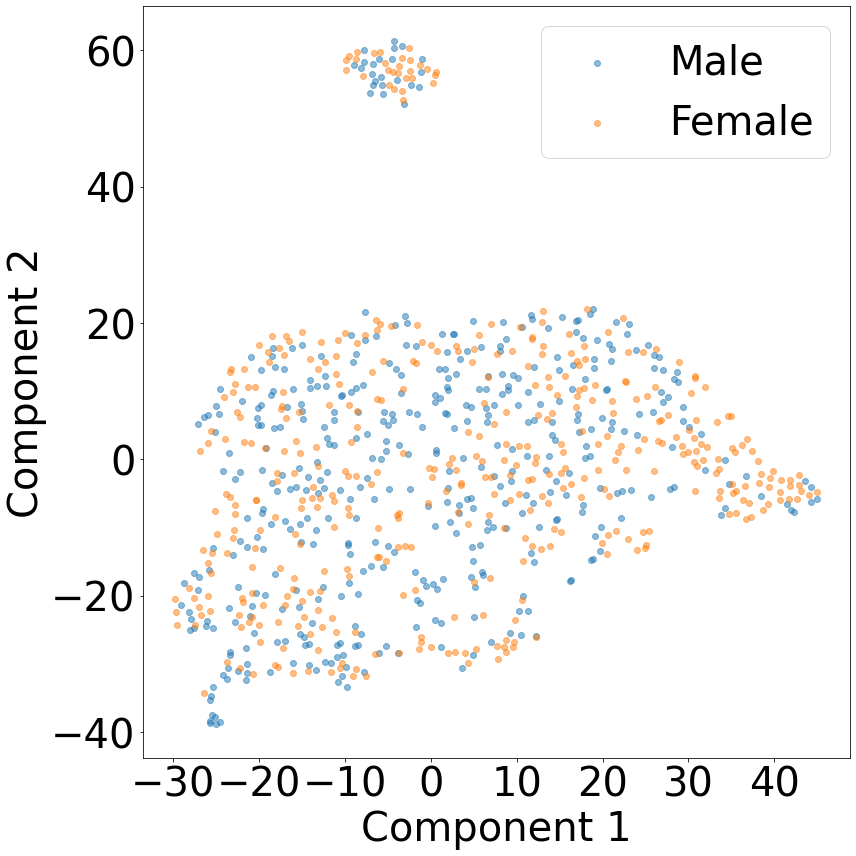

In [11]:
cur_key = 'gender'
use_label = ['Male','Female']
plt.figure(figsize=(12,12))
fontsize=40
label = []
test_user_ids = mean_users
for user in test_user_ids:
    cur_label = demo_dict['Self-Identified Gender'][user]
    label.append(cur_label)
label = np.array(label)
for c_label in use_label:
    cur_ids = np.where(label == c_label)[0]
    plt.scatter(X_reduced[cur_ids,0],X_reduced[cur_ids,1], label = c_label,alpha=0.5)
plt.legend(fontsize=fontsize)
plt.xlabel('Component 1',fontsize=fontsize)
plt.ylabel('Component 2',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()
plt.savefig('plots/' + cur_key + '_t_sne_lohr.pdf')
plt.show()

### Visualize by Ethnicity

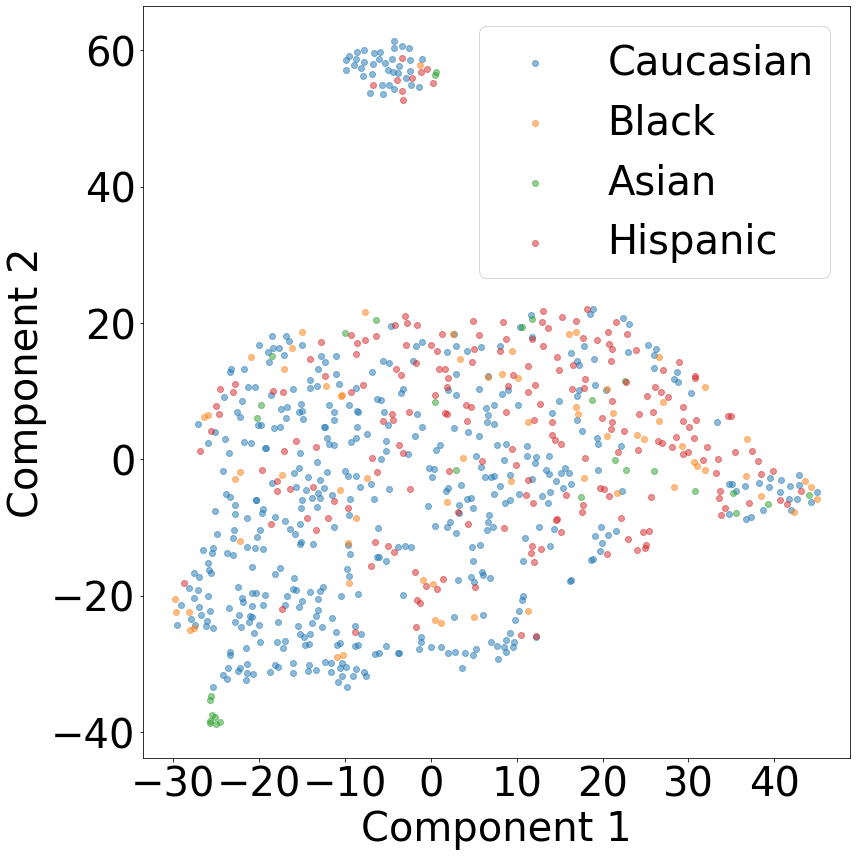

In [12]:
cur_key = 'ethnicity'
use_label = ['Caucasian','Black','Asian','Hispanic']
plt.figure(figsize=(12,12))
fontsize=40
label = []
test_user_ids = mean_users
for user in test_user_ids:
    cur_label = demo_dict['normalized Ethnicity'][user]
    label.append(cur_label)
label = np.array(label)
for c_label in use_label:
    cur_ids = np.where(label == c_label)[0]
    plt.scatter(X_reduced[cur_ids,0],X_reduced[cur_ids,1], label = c_label,alpha = 0.5)
plt.legend(fontsize=fontsize)
plt.xlabel('Component 1',fontsize=fontsize)
plt.ylabel('Component 2',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()
plt.savefig('plots/' + cur_key + '_t_sne_lohr.pdf')
plt.show()

### Visualize by Age

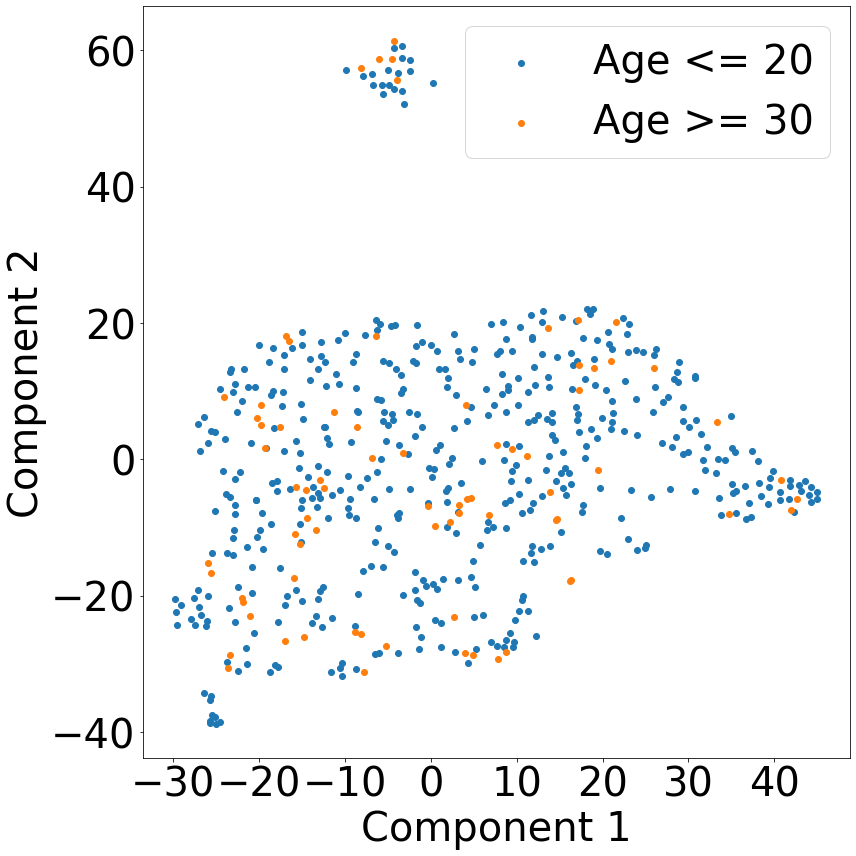

In [13]:
cur_key = 'age'
use_label = ['Age <= 20','Age >= 30']
plt.figure(figsize=(12,12))
fontsize=40
label = []
test_user_ids = mean_users
for user in test_user_ids:
    cur_label = demo_dict['age_class'][user]
    label.append(cur_label)
label = np.array(label)
for c_label in use_label:
    cur_ids = np.where(label == c_label)[0]
    plt.scatter(X_reduced[cur_ids,0],X_reduced[cur_ids,1], label = c_label)
plt.legend(fontsize=fontsize)
plt.xlabel('Component 1',fontsize=fontsize)
plt.ylabel('Component 2',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()
plt.savefig('plots/' + cur_key + '_t_sne_lohr.pdf')
plt.show()